# Exercise 5 - Variational quantum eigensolver
The following notebook contains my solution for exercise 5 of the IBM Quantum Challenge 2021. This solution has $\delta E_{chem} \approx 2.339$ mHa, uses 32 parameters in the ansatz, and has the lowest score possible of 3 CNOTs. My name is Emilio Peláez and my GitHub profile is [@epelaaez](https://github.com/epelaaez) if you want to check it out!

### Imports
The next cell imports everything needed for this notebook.

In [68]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 
from qiskit.algorithms import VQE
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from IPython.display import display, clear_output

### Helper functions
I defined two functions to help me evaluate my solution. First, one that gets the score of the ansatz, i.e. the number of CNOTs it uses.

In [69]:
def getScore(ansatz):    
    pass_ = Unroller(['u', 'cx'])
    pm = PassManager(pass_)
    ansatz_tp = pm.run(ansatz)
    cnots = ansatz_tp.count_ops()['cx']
    print("Score:", cnots)

Then one that gets the chemical accuracy of my solution.

In [96]:
def accuracy(vqe_energy, exact_energy, threshold):
    print("Exact ground energy:", exact_energy)
    print("Energy from VQE:", vqe_energy)
    print("Error:", (vqe_energy - exact_energy) * 1000)
    print("Pass:", (vqe_energy - exact_energy) * 1000 <= threshold)

I also defined a callback functioned to be called in each iteration of the optimizer which helps keep track of its performance. (This function is identical to the one defined for the tutorial part of the notebook but with a few lines of code removed.)

In [90]:
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)

### Solution

First, we define the molecule we are going to simulate in this challenge. The cell below gives us all information about the LiH molecule with interatomic distance 1.5474.

In [83]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Now, we freeze two electrons that don't contribute importantly to the molecular interactions to reduce the number of qubits needed and focus on the valence electrons. Then we just get the second-quantized operators and Hamiltonian as shown in the tutorial part of the challenge notebook.

In [84]:
problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(remove_orbitals=[3,4])]) # Freeze orbitals 3 and 4
second_q_ops = problem.second_q_ops() # Second-quantized operators
main_op = second_q_ops[0] # Hamiltonian

Next, we use a ParityMapper to use in our simulation. Using this mapper along with the parameter `two_qubit_reduction` set to `True` allows us to reduce the number of qubits by two. We also set the parameter `z2symmetry_reduction` to `[1,1]`. This tells the qubit converter to search for symmetries it can exploit to reduce the number of qubits further.

In [85]:
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1])
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)
print("Number of qubits:", qubit_op.num_qubits)

Number of qubits: 4


We see that the number of qubits in our simulation is just 4, which allows us to connect all qubits using few CNOT gates. Now, we get the HartreeFock state to use as our initial state. Notice that it is different from the initial state used in the tutorial part for the H$_2$ molecule.

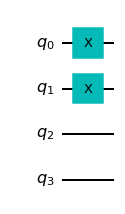

In [86]:
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw('mpl')

The next cell builds our ansatz. We are going to exploit the fact that we managed to bring down the number of qubits to 4 by using the TwoLocal circuit and setting `entanglement` to `'linear'`. This makes the total number of CNOT gates three, which make a ladder from qubit 0 through qubit 3. At first, I was using the `rotation_blocks` array given in the tutorial part, which just consisted of two layers: one R$_z$ followed by one R$_y$. However, running the simulation with this ansatz caused the optimizer to halt after very few iterations, resulting in a really inaccurate result. Thus, I decided to add another layer of R$_z$ and R$_y$. Also notice that `skip_final_rotation_layer` is set to `False`; I did this to have rotation blocks on both sides of the CNOT stair and thus allow for better optimization. (**Note:** the first two X gates in qubits 0 and 1 are from the init circuit, not the ansatz.)

Score: 3


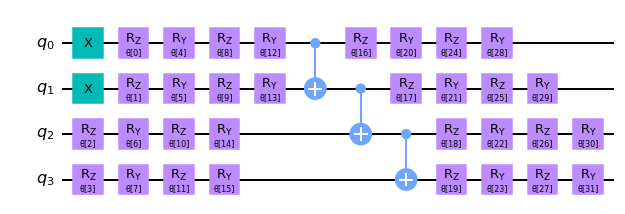

In [87]:
rotation_blocks = ['rz', 'ry', 'rz', 'ry']
entanglement_blocks = 'cx'
entanglement = 'linear'
repetitions = 1
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=False)
ansatz.compose(init_state, front=True, inplace=True)
getScore(ansatz)
ansatz.draw('mpl')

Then, I just declared the backend and optimizer used in the simulation. I chose to use the `COBYLA` optimizer because I found it to be the best for my specific ansatz. It was also the one that got me the lowest error along with the lowest cost in the tutorial, so I thought it would also work in this case. Moreover, I set `maxiter=5000` because I found that the optimizer halted around that number even if I had the maximum set higher.

In [88]:
backend = Aer.get_backend('statevector_simulator')
optimizer = COBYLA(maxiter=5000)

The next cell just runs VQE, nothing can be done here since it just calls the Qiskit function. We make use of the `callback` function that we defined on the **Helper functions** section.

In [98]:
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print("Calculated eigenvalue:", result.eigenvalue)
print("Optimizer evaluations:", result.optimizer_evals)

Calculated eigenvalue: -1.0863669407824805
Optimizer evaluations: 4542


Now, we calculate the exact ground energy to compare it with the result from our simulation. We do this using Numpy.

In [95]:
solver = NumPyMinimumEigensolverFactory()
calc = GroundStateEigensolver(converter, solver)
result_exact = calc.solve(problem)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact ground energy:", exact_energy)

Exact ground energy: -1.0887060157347386


Finally, we use the `accuracy` function defined at the beggining of this notebook to get the chemical accuracy of our simulation.

In [99]:
accuracy_threshold = 4.0 # in mHa
vqe_energy = result.optimal_value
accuracy(vqe_energy, exact_energy, accuracy_threshold)

Exact ground energy: -1.0887060157347386
Energy from VQE: -1.0863669407824805
Error: 2.3390749522580467
Pass: True


Here, we can see that $\delta E_{chem} \approx 2.339 < 4$ mHa, meaning that we got the desired chemical accuracy with the lowest cost possible of 3 CNOT gates. Just to make sure this is correct, the following cell runs the challenge grader (and we see our solution is actually correct!).

In [94]:
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

